## Wu-Yang Method for KS Inversion
Please check the original paper of the Wu-Yang method: [Qin Wu, Weitao Yang, J. Chem. Phys. 118, 2498 (2003)](https://aip.scitation.org/doi/abs/10.1063/1.1535422?casa_token=caPxLNp1Jm8AAAAA:WsOECHVnX79_uiv6Gxx7DcxXcQ2QTl-_wRKNVekhXK9gIvVZ22T2oFk9_hya4Tc8C7iixmki3YceYA).

In [1]:
import psi4
import matplotlib.pyplot as plt
import numpy as np

psi4.set_options({"save_jk" : True})
psi4.set_memory(int(2.50e9))
psi4.core.clean()

import n2v

---
### Perform target calculation with Psi4. 
Store wavefunction (wfn) object

In [2]:
Be = psi4.geometry( 
""" 
0 1
Be
noreorient
nocom
units bohr
symmetry c1
""" )

psi4.set_options({"reference" : "rhf"})  # Spin-Restricted

# IMPORTANT NOTE: psi4.energy does not update cc densities. So we calculate dipole moments instead.
wfn = psi4.properties("ccsd/aug-cc-pvtz",  return_wfn=True, molecule=Be, property=['dipole'])[1]

---
### Invert! 
$$v_{Kohn-Sham}=v_{ext}+v_{guide}+v_{rest}$$
With the guide potential $v_{guide}=v_{Fermi-Amaldi}$ and the rest potential $v_{rest}$ on the potential basis set (pbs) "aug-cc-pvqz".

In [3]:
# Build inverter and set target
ibe = n2v.Inverter(wfn, pbs="aug-cc-pvqz")

# Inverter with WuYang method, guide potention v0=Fermi-Amaldi
ibe.invert("WuYang", guide_potential_components=["fermi_amaldi"])

Optimization Successful within 2 iterations! |grad|=6.10e-04


---
### Visualization
#### Visualization of the potentials. 

#### Since this is a 1-D system, let's first plot it alone x axis.

Building grids

In [4]:
x = np.linspace(-5,5,101)
y = np.zeros_like(x)
z = np.zeros_like(x)
grids = np.array([x,y,z])
grids.shape

(3, 101)

Or the grids can be generate alternatively by np.meshgrid and flatten.

In [5]:
grids_temp, _ = ibe.generate_grids(x=x, y=[0], z=[0])
np.allclose(grids_temp, grids)

True

Get Hartree and Fermi-Amaldi potentials

In [6]:
vH, vFA = ibe.on_grid_esp(grid=grids)[1:3]
assert np.allclose(vFA, vH * (1-1/(ibe.nalpha+ibe.nbeta)))

Get exchange-correlation potentials.
\begin{align}
v_{xc}
&=v_{Kohn-Sham}-v_{Hartree}-v_{ext}\\
&=v_{guide}+v_{rest}-v_{Hartree}
\end{align}

In [7]:
vrest = ibe.on_grid_ao(ibe.v_pbs, grid=grids, basis=ibe.pbs)  # Note that specify the basis set 
                                                               # that vrest is on.

In [8]:
vxc = vFA + vrest - vH

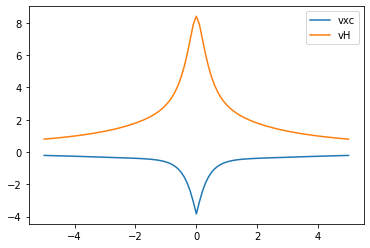

In [9]:
plt.plot(x, vxc, label="vxc")
plt.plot(x, vH, label="vH")
plt.legend()

#### Let's plot it on xy plane.

In [10]:
x = np.linspace(-5,5,101)
y = np.linspace(-4,4,81)
z = [0]
grids, shape = ibe.generate_grids(x=x, y=y, z=z)  # shape is saved for futrue use as reshape the grid back to 2D.
grids.shape

(3, 8181)

In [11]:
vext, vH, vFA = ibe.on_grid_esp(grid=grids)[:3]
vrest = ibe.on_grid_ao(ibe.v_pbs, grid=grids, basis=ibe.pbs)
vxc = vFA + vrest - vH

Reshape things back.

In [12]:
vxc = vxc.reshape(shape)
vH = vH.reshape(shape)
vext = vext.reshape(shape)
print(vxc.shape, vH.shape, vext.shape)

(101, 81, 1) (101, 81, 1) (101, 81, 1)


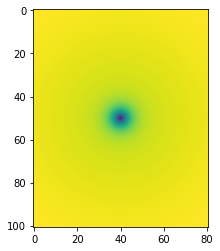

In [13]:
plt.imshow(vxc[:,:,0], interpolation="bicubic")

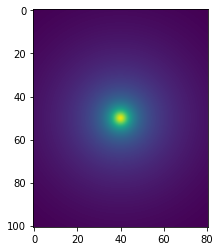

In [14]:
plt.imshow(vH[:,:,0], interpolation="bicubic")

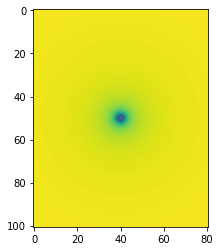

In [15]:
plt.imshow(vext[:,:,0], interpolation="bicubic")